In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import pandas as pd

2024-12-21 23:48:34.121689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/

In [2]:
# Load the dataset
data = pd.read_csv('AMAZON-REVIEW-DATA-CLASSIFICATION.csv').sample(n=5000, random_state=42)
data.head()

,reviewText,summary,verified,time,log_votes,isPositive
46730,"Well I mean, you have to purchase some copy of...",Three Stars,True,1445472000,0.000000,0.0
48393,"I am still getting to know this software, had ...",Quicken 2015 Mac Much Improved over Quicken 20...,False,1424995200,0.000000,1.0
41416,Has good features not available in other versi...,"Good package, but I personally could have done...",True,1385337600,0.000000,0.0
34506,Do not download if you are purchasing for an i...,I just wasted my money,True,1522540800,0.000000,0.0
43725,"I have tried similar products, but this one ca...",This is great!,False,1057708800,1.098612,1.0


In [3]:
data.shape

(5000, 6)

In [4]:
# Ensure no missing values in the target column
data['isPositive'] = data['isPositive'].fillna(0).astype(int)
data['reviewText'] = data['reviewText'].fillna("")  # Ensure no missing values in the text column

In [5]:
# Split the data
texts = data['reviewText']
labels = data['isPositive']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [6]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [9]:
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})

In [10]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
# Define the BERT sentiment classifier model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
from evaluate import load
import evaluate


def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return metric.compute(predictions=predictions, references=labels)

In [14]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/sentiment_analysis",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,  # Increased epochs for early stopping
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_933/3662157354.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.312046,0.872000
2,0.290800,0.357591,0.881000
3,0.290800,0.505424,0.886000
4,0.094900,0.579648,0.898000


TrainOutput(global_step=1000, training_loss=0.1928678207397461, metrics={'train_runtime': 3049.5619, 'train_samples_per_second': 13.117, 'train_steps_per_second': 0.82, 'total_flos': 1052444221440000.0, 'train_loss': 0.1928678207397461, 'epoch': 4.0})

In [16]:
trainer.evaluate()

{'eval_loss': 0.3120461404323578,
 'eval_accuracy': 0.872,
 'eval_runtime': 52.4587,
 'eval_samples_per_second': 19.063,
 'eval_steps_per_second': 1.201,
 'epoch': 4.0}

In [20]:
import pandas as pd
from sklearn.metrics import classification_report

# Get predictions from the validation dataset
predictions = trainer.predict(val_dataset)

# Extract logits, true labels, and predictions
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = logits.argmax(axis=-1)

# If the val_dataset doesn't have direct access to original columns, use the original dataset
# Assuming `val_texts` contains the original texts and other metadata in a DataFrame called `val_metadata`
val_metadata = pd.DataFrame({
    'reviewText': val_texts.tolist(),
    'summary': ['N/A'] * len(val_texts),  # Add 'summary' if it's not available
    'verified': ['N/A'] * len(val_texts),  # Replace with real values if available
    'time': ['N/A'] * len(val_texts),  # Replace with real values if available
    'log_votes': [0] * len(val_texts),  # Replace with real values if available
    'isPositive': val_labels.tolist()  # True labels
})

# Add predictions to the metadata
val_metadata['predictions'] = predicted_labels

# Display the table
val_metadata.head(20)




,reviewText,summary,verified,time,log_votes,isPositive,predictions
0,"Not quite as user-friendly as Turbo Tax, but I...",N/A,N/A,N/A,0,1,1
1,"I've used Quicken versions 2003, 2006, 2008 an...",N/A,N/A,N/A,0,0,0
2,No product support do not buy..,N/A,N/A,N/A,0,0,0
3,It work,N/A,N/A,N/A,0,1,1
4,"Overall a robust and reliable product, but:\n\...",N/A,N/A,N/A,0,0,0


In [21]:
# Display the table
val_metadata.head(20)

,reviewText,summary,verified,time,log_votes,isPositive,predictions
0,"Not quite as user-friendly as Turbo Tax, but I...",N/A,N/A,N/A,0,1,1
1,"I've used Quicken versions 2003, 2006, 2008 an...",N/A,N/A,N/A,0,0,0
2,No product support do not buy..,N/A,N/A,N/A,0,0,0
3,It work,N/A,N/A,N/A,0,1,1
4,"Overall a robust and reliable product, but:\n\...",N/A,N/A,N/A,0,0,0
5,I was a MS Money 07 user until I switched to a...,N/A,N/A,N/A,0,0,0
6,It is working well in my computer. I have been...,N/A,N/A,N/A,0,1,1
7,I read thru the bible every year this is my fa...,N/A,N/A,N/A,0,1,1
8,It's a really good product and works really go...,N/A,N/A,N/A,0,1,1
9,I met my expectations and filled my needs for ...,N/A,N/A,N/A,0,1,1


In [22]:
# Save the model
model.save_pretrained("saved_model")

# Save the tokenizer
tokenizer.save_pretrained("saved_model")


('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')

In [23]:
# Save the table to a CSV file if needed
val_metadata.to_csv("val_predictions_table.csv", index=False)

In [24]:
# Generate a classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.78      0.92      0.84       371
           1       0.94      0.85      0.89       629

    accuracy                           0.87      1000
   macro avg       0.86      0.88      0.87      1000
weighted avg       0.88      0.87      0.87      1000



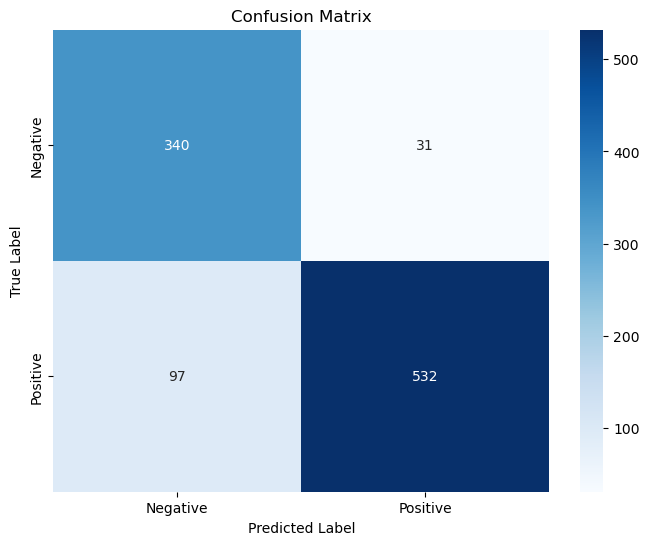

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the validation dataset
predictions = trainer.predict(val_dataset)

# Extract true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = predictions.predictions.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
